Script Name: SZ_analysis  
Author: Fatemeh Delavari  
Version: 7.0 (10/15/2024)  
Description: Performs graph analysis on epileptic EEGs

In [3]:
import mne
import os
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from scipy.signal import hilbert, butter, filtfilt
from mne.preprocessing import ICA
from scipy.fft import fft, ifft
from scipy.stats import norm
from scipy.signal import hann, periodogram
from scipy.ndimage import uniform_filter1d

In [4]:
simplified_names = [
    'FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4',
    'T5', 'T6', 'FZ', 'CZ', 'PZ'
]

# Define positions (in meters) for the channels
pos = {'FP1': (-0.03, 0.08, 0.05),
'FP2': (0.03, 0.08, 0.05),
'F3': (-0.04, 0.04, 0.06),
'F4': (0.04, 0.04, 0.06),
'C3': (-0.05, 0.00, 0.04),
'C4': (0.05, 0.00, 0.04),
'P3': (-0.04, -0.04, 0.03),
'P4': (0.04, -0.04, 0.03),
'O1': (-0.03, -0.08, 0.02),
'O2': (0.03, -0.08, 0.02),
'F7': (-0.07, 0.05, 0.06),
'F8': (0.07, 0.05, 0.06),
'T3': (-0.08, 0.00, 0.04),
'T4': (0.08, 0.00, 0.04),
'T5': (-0.06, -0.05, 0.03),
'T6': (0.06, -0.05, 0.03),
'FZ': (0.00, 0.03, 0.07),
'CZ': (0.00, 0.00, 0.06),
'PZ': (0.00, -0.03, 0.05)}

# Define the Butterworth filter parameters with filtfilt applied
iir_params = dict(order=6, ftype='butter', output='sos')

num_channels = 19

frequency_bands = {
    "Delta": [1, 4],
    "Theta": [4, 8],
    "Alpha": [8, 13],
    "Beta": [13, 30],
    "Gamma": [30, 40]
}

epoch_length = 1  # in seconds
n_nodes = 19
n_surrogates = 100
n_surrogate_epochs = 10

# List of target labels (case-insensitive)
target_labels = ['bckg', 'seiz', 'fnsz', 'gnsz', 'spsz', 'cpsz', 'absz', 
                 'tnsz', 'cnsz', 'tcsz', 'atsz', 'mysz', 'nesz']

# Parameters
extra_points = 120  # Extra points before and after seizure
num_intervals = 10  # Number of intervals for seizure portion
before_after_intervals = 2  # For before and after


In [5]:
def bandpass_filter(data, sfreq, low_freq, high_freq):
    """
    Band-pass filter the data.
    
    Parameters:
    data (ndarray): The input signal of shape (n_channels, n_times)
    sfreq (float): The sampling frequency
    low_freq (float): The lower bound of the frequency range
    high_freq (float): The upper bound of the frequency range
    
    Returns:
    filtered_data (ndarray): The band-pass filtered signal
    """
    nyquist = 0.5 * sfreq
    low = low_freq / nyquist
    high = high_freq / nyquist
    b, a = butter(4, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data, axis=1)
    return filtered_data

In [6]:
def calculate_plv(phasedata):
    """
    Calculate the Phase Locking Value (PLV) between pairs of EEG channels.
    
    Parameters:
    eeg_data (ndarray): EEG data of shape (n_channels, n_times)
    sfreq (float): Sampling frequency of the EEG data
    low_freq (float): Lower frequency bound for band-pass filter (default 8 Hz)
    high_freq (float): Upper frequency bound for band-pass filter (default 13 Hz)
    
    Returns:
    plv_matrix (ndarray): PLV matrix of shape (n_channels, n_channels)
    """
    n_channels, n_times = phasedata.shape
    plv_matrix = np.zeros((n_channels, n_channels))
    
    # Calculate PLV
    for i in range(n_channels):
        for j in range(i + 1, n_channels):
            phase_diff = phasedata[i] - phasedata[j]
            plv = np.abs(np.sum(np.exp(1j * phase_diff)) / n_times)
            plv_matrix[i, j] = plv
            plv_matrix[j, i] = plv  # PLV is symmetric
    
    return plv_matrix

In [7]:
# Helper function to create graph from PLV matrix
def create_graph(plv_matrix, ch_names):
    G = nx.Graph()
    for i, ch1 in enumerate(ch_names):
        for j, ch2 in enumerate(ch_names):
            if i < j:  # To avoid duplicate edges
                weight = plv_matrix[i, j]
                G.add_edge(ch1, ch2, weight=weight)
    return G

In [8]:
# Helper function to create graph from PLV matrix
def create_graph_bi(plv_matrix, ch_names):
    
    G = nx.Graph()
    for i, ch1 in enumerate(ch_names):
        for j, ch2 in enumerate(ch_names):
            if i < j:  # To avoid duplicate edges
                weight = plv_matrix[i, j]
                if weight == 1:
                    G.add_edge(ch1, ch2, weight=1)  # Binary edge
    return G

In [9]:
def epoch_data(data, sfreq, epoch_length):
    n_channels, n_samples = data.shape
    epoch_samples = int(epoch_length * sfreq)
    n_epochs = n_samples // epoch_samples
    epochs = np.array_split(data[:, :n_epochs * epoch_samples], n_epochs, axis=1)
    return epochs, n_epochs

In [10]:
def smooth_power_spectrum(power_spectrum, window_size=5):
    return uniform_filter1d(power_spectrum, size=window_size)

def compute_power_spectrum(time_series, fs):
    """
    Compute the power spectrum of the input time series using Hann window 
    and returns the one-sided power spectrum.
    
    Parameters:
    - time_series: 1D array of the signal
    - fs: Sampling frequency of the signal
    
    Returns:
    - freqs: Frequencies corresponding to the power spectrum
    - power_spectrum: One-sided power spectrum
    """
    # Length of the signal
    L = len(time_series)
    
    # Apply Hann window
    hann_window = hann(L)
    windowed_data = time_series * hann_window
    
    # Compute FFT
    fft_values = np.fft.fft(windowed_data)
    
    # Compute two-sided power spectrum
    P2 = np.abs(fft_values / L) ** 2
    
    # One-sided power spectrum (P1)
    P1 = P2[:L//2 + 1]
    P1[1:-1] = 2 * P1[1:-1]  # Double all but the first and last component
    
    # Frequencies corresponding to the power spectrum
    freqs = np.fft.fftfreq(L, 1/fs)[:L//2 + 1]
    
    power_spectrum = P1
    spower_spectrum = smooth_power_spectrum(power_spectrum, window_size=5)
    return freqs, spower_spectrum

In [11]:
def compute_whitened_residuals(time_series, avg_spectrum):
    """
    Compute the whitened residuals of the time series using the one-sided average power spectrum.
    
    Parameters:
    - time_series: The input signal (1D array)
    - avg_spectrum: The one-sided average power spectrum (should have length L//2 + 1, where L is the length of the time series)
    
    Returns:
    - residuals: The whitened residuals (1D array, same length as time_series)
    """
    # Length of the signal
    L = len(time_series)

    # Apply Hann window
    hann_window = hann(L)
    windowed_data = time_series * hann_window
    
    # Compute FFT
    fft_values = np.fft.fft(windowed_data)
        
    spectrum = fft_values
    
    # Create a two-sided spectrum from the one-sided avg_spectrum
    avg_spectrum_full = np.zeros(L)
    avg_spectrum_full[:L//2 + 1] = avg_spectrum
    avg_spectrum_full[L//2+1:] = np.flip(avg_spectrum[1:-1])
    
    # Avoid division by zero by adding a small constant if needed
    eps = 1e-10  # Small constant to prevent division by zero
    avg_spectrum_full = np.where(avg_spectrum_full == 0, eps, avg_spectrum_full)
    
    # Compute the whitened spectrum (divide by sqrt of avg_spectrum_full)
    whitened_spectrum = spectrum / np.sqrt(abs(avg_spectrum_full))
    
    # Compute the residuals by applying the inverse FFT
    residuals = ifft(whitened_spectrum)
    
    # Return the real part of the residuals (since the result might have very small imaginary values)
    return np.real(residuals)

In [12]:
def resample_with_replacement(data):
    """Resample data with replacement."""
    indices = np.random.randint(0, data.shape, data.shape)
    return data[indices]

In [13]:
def feature_extract(graph):
    features = {}
    # Calculate graph density
    features['density'] = nx.density(graph)
    # Average Clustering Coefficient
    if graph.number_of_edges() > 0:
      features['avg_clustering'] = nx.average_clustering(graph)
    else:
      features['avg_clustering'] = 0 
    # Modularity requires community detection, using the 'community' package from 'python-louvain'
    # You may need to install it using: pip install python-louvain
    from community import community_louvain
    # Find communities using the Louvain method
    if graph.number_of_edges() > 0:
        partition = community_louvain.best_partition(graph)
        features['modularity'] = community_louvain.modularity(partition, graph)
    else:
        partition = {}  # An empty partition, or you can set this to another default value if necessary
        features['modularity'] = 0  # Or set to None, or any other default value
    return features

In [14]:
def feature_extract_w(graph):
    features_w = {}
    # features_w['characteristic_path_length'] = nx.average_shortest_path_length(graph, weight='weight')
        # Create a new graph with inverted weights
    inverted_graph = nx.Graph()
    for u, v, d in graph.edges(data=True):
        if d['weight'] != 0:  # Ensure the weight is non-zero to avoid division by zero
            inverted_graph.add_edge(u, v, weight=1.0 / d['weight'])
    # Calculate the characteristic path length using the inverted weights
    features_w['characteristic_path_length'] = nx.average_shortest_path_length(inverted_graph, weight='weight')
    return features_w

In [15]:
# Function to calculate average values over intervals
def calculate_interval_averages(data_segment, num_intervals):
    length = len(data_segment)
    interval_size = length // num_intervals
    averages = []
    
    for i in range(num_intervals):
        start_idx = i * interval_size
        end_idx = (i + 1) * interval_size if i < num_intervals - 1 else length
        interval_data = data_segment[start_idx:end_idx]
        averages.append(np.mean(interval_data))
    
    return averages

In [16]:
# Specify the folder path containing the EDF files
folder_path = 'C:/Users/Atena/Documents/edf'
# Specify the folder path containing the CSV files
folder_path_csv = 'C:/Users/Atena/Documents/csv'

In [17]:
file_num = -1
bckg_only = []
sz_containing = []
results = {}
all_results = {}

# Loop through all the EDF files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.edf'):  # Check if the file is an EDF file
        file_path = os.path.join(folder_path, file_name)
        
        file_num = file_num + 1

        # Strip the .edf extension and look for the corresponding .csv file
        base_name = os.path.splitext(file_name)[0]
        csv_file_name = base_name + '.csv'
                
        # Check if the corresponding CSV file exists
        if csv_file_name in os.listdir(folder_path_csv):
            csv_file_path = os.path.join(folder_path_csv, csv_file_name)
            # Read the CSV file
            df = pd.read_csv(csv_file_path, comment='#') 

            # Extract the unique labels from the 'label' column, ignoring case sensitivity
            unique_labels = df['label'].str.lower().unique()

            # Find matching labels (case-insensitive comparison)
            matching_labels = [label for label in unique_labels if label in target_labels]

            # Convert the label column to lowercase for case-insensitive matching
            df['label'] = df['label'].str.lower()

            # Filter the rows that match the target labels
            matching_df = df[df['label'].isin(target_labels)]

            # Check if any label contains 'sz'
            if any('sz' in label for label in unique_labels):
                sz_containing.append(file_num)
            
                # Read the EDF file
                raw = mne.io.read_raw_edf(file_path, preload=True)
                sampfreq = int(raw.info['sfreq'])
                chs = raw.ch_names
                if any('REF' in channel for channel in chs):
                    selected_channels = ['EEG FP1-REF', 'EEG FP2-REF', 'EEG F7-REF', 'EEG F3-REF', 
                            'EEG FZ-REF', 'EEG F4-REF', 'EEG F8-REF', 'EEG T3-REF', 
                            'EEG C3-REF', 'EEG CZ-REF', 'EEG C4-REF', 'EEG T4-REF', 
                            'EEG T5-REF', 'EEG P3-REF', 'EEG PZ-REF', 'EEG P4-REF',
                            'EEG T6-REF', 'EEG O1-REF', 'EEG O2-REF']
                    montage_positions = {ch_name: np.array(pos[ch_name.replace('EEG ', '').replace('-REF', '')])
                            for ch_name in selected_channels}
                else:
                    selected_channels = ['EEG FP1-LE', 'EEG FP2-LE', 'EEG F7-LE', 'EEG F3-LE', 'EEG FZ-LE', 'EEG F4-LE', 'EEG F8-LE', 'EEG T3-LE', 'EEG C3-LE', 'EEG CZ-LE', 'EEG C4-LE', 'EEG T4-LE', 'EEG T5-LE', 'EEG P3-LE', 'EEG PZ-LE', 'EEG P4-LE', 'EEG T6-LE', 'EEG O1-LE', 'EEG O2-LE']
                    # montage_positions = {ch_name: np.array(pos[ch_name.replace('EEG ', '').replace('-LE', '')])
                    #         for ch_name in selected_channels}
                raw_selected = raw.copy()
                # Select the specified channels
                raw_selected = raw_selected.pick_channels(selected_channels)

                # Filter the data
                preprocEEG = raw_selected.copy()
                # Band-pass filter the data using a 6th-order Butterworth filter with filtfilt applied
                preprocEEG.filter(l_freq=1.0, h_freq=40, method='iir', iir_params=iir_params, phase='zero')
                # Notch filter to remove power line noise (assuming 60 Hz)
                preprocEEG.notch_filter(freqs=60.0)

                # Applying ICA: Create a custom montage
                montage = mne.channels.make_dig_montage(ch_pos=montage_positions, coord_frame='head')
                # Apply the montage to the data
                preprocEEG.set_montage(montage)
                eegICA = preprocEEG.copy()
                # Set up the ICA object, specifying the number of components to compute
                ica = ICA(n_components=19, random_state=97, max_iter=1000)
                # Fit ICA to the raw data
                ica.fit(eegICA)
                emg_inds, scores = ica.find_bads_muscle(eegICA, threshold = 0.95)
                ica.exclude.extend(emg_inds)
                # Apply the ICA to the raw data
                ica.apply(eegICA)

                eegICA = preprocEEG

                eegICA.set_eeg_reference(ref_channels='average')

                eeg_data, times = eegICA[:]

                # duration_seconds = eeg_data.shape[1] / sampfreq

                epoch_samples = int(epoch_length * sampfreq)
                
                results[file_num] = {}
                for band, freq_range in frequency_bands.items():
                    low_freq, high_freq = freq_range
                    # Band-pass filter the data in the specified frequency band
                    eeg_data_filtered = bandpass_filter(eeg_data, sampfreq, low_freq, high_freq)
                    # Compute the analytic signal (Hilbert transform) to get the phase
                    analytic_signal = hilbert(eeg_data_filtered, axis=1)
                    phase_data = np.angle(analytic_signal)
                    phase_epochs, n_epochs  = epoch_data(phase_data[:19, :], sampfreq, epoch_length)
                    plv_matrix = np.zeros((19, 19, n_epochs, high_freq-low_freq))
                    for freq in range(low_freq, high_freq):
                        freq_n = freq-low_freq
                        # Band-pass filter the data in the specified frequency band
                        eeg_data_filtered = bandpass_filter(eeg_data, sampfreq, freq, freq+1)
                        # Compute the analytic signal (Hilbert transform) to get the phase
                        analytic_signal = hilbert(eeg_data_filtered, axis=1)
                        phase_data = np.angle(analytic_signal)
                        phase_epochs, n_epochs = epoch_data(phase_data, sampfreq, epoch_length)
                        epoch_n = 0
                        for epoch in phase_epochs:
                            plv_matrix[:, :, epoch_n, freq_n] = calculate_plv(epoch)
                            epoch_n = epoch_n + 1
                    plv_all = np.mean(plv_matrix, axis = 3)

                    graphs = []
                    epoch_n = 0
                    for epoch in phase_epochs:
                        graph = create_graph(plv_all[:, :, epoch_n], selected_channels)
                        graphs.append(graph)
                        epoch_n = epoch_n + 1

                    # Finding appropriate Threshold using Frequency Domain Bootstrap Method  
                    # Compute power spectrum
                    freqs, spower_spectrum = compute_power_spectrum(eeg_data[0, :10*sampfreq], sampfreq)
                    # Step 1: Compute power spectrum for each time series and average them
                    # time_series is an array of shape (19, x)
                    power_spectra = np.array([compute_power_spectrum(eeg_data[i, :10*sampfreq], sampfreq)[1] for i in range(eeg_data.shape[0])])
                    avg_spectrum = np.mean(power_spectra, axis=0)
                    # Step 2: Compute the whitened residuals for each time series
                    whitened_residuals = np.array([compute_whitened_residuals(eeg_data[i, :10*sampfreq], avg_spectrum) for i in range(eeg_data.shape[0])])
                    n_data_points = eeg_data[:, :10*sampfreq].shape[1]
                    surrogate_data = np.zeros((n_surrogates, n_nodes, n_data_points), dtype=complex)  
                    for i in range(n_surrogates):
                        for node in range(n_nodes):
                            # Resample residuals and compute surrogate data
                            resampled_residuals = resample_with_replacement(whitened_residuals[node])
                            # Length of the signal
                            L = whitened_residuals.shape[1]
                            # Create a two-sided spectrum from the one-sided avg_spectrum
                            avg_spectrum_full = np.zeros(L)
                            avg_spectrum_full[:L//2 + 1] = avg_spectrum
                            avg_spectrum_full[L//2+1:] = np.flip(avg_spectrum[1:-1])
                            surrogate_spectrum = fft(resampled_residuals) * np.sqrt(abs(avg_spectrum_full)) 
                            surrogate_data[i, node] = ifft(surrogate_spectrum)
                    surrogate_datar = np.real(surrogate_data) 
                    plv_matrix_surrogate = np.zeros((19, 19, n_surrogate_epochs, high_freq-low_freq, n_surrogates))
                    for surrog_num in range(n_surrogates):
                        for freq in range(low_freq, high_freq):
                            freq_n = freq-low_freq
                            # Band-pass filter the data in the specified frequency band
                            eeg_data_filtered = bandpass_filter(surrogate_datar[surrog_num, :, :], sampfreq, freq, freq+1)
                            # Compute the analytic signal (Hilbert transform) to get the phase
                            analytic_signal = hilbert(eeg_data_filtered, axis=1)
                            phase_data = np.angle(analytic_signal)
                            phase_Seg = phase_data.copy()
                            surrogate_phase_epochs, _ = epoch_data(phase_Seg, sampfreq, epoch_length)
                            epoch_n = 0
                            for epoch in surrogate_phase_epochs:
                                plv_matrix_surrogate[:, :, epoch_n, freq_n, surrog_num] = calculate_plv(epoch)
                                epoch_n = epoch_n + 1
                    plv_surrogate_all = np.mean(plv_matrix_surrogate, axis = 3)
                    surrogate_plv = plv_surrogate_all.reshape(19, 19, -1)
                    surrogate_distribution = surrogate_plv.flatten()
                    p_values = np.zeros((n_nodes, n_nodes, n_epochs))
                    for i in range(n_nodes):
                        for j in range(i+1, n_nodes):
                            for epoch in range(n_epochs):
                                original_value = plv_all[i, j, epoch]
                                p_values[i, j, epoch] = np.mean(surrogate_distribution >= original_value)
                                p_values[j, i, epoch] = p_values[i, j, epoch]  # Since it's symmetric

                    plv_bi= (p_values<0.05).astype(int)
                    ratio_edge = np.sum(plv_bi)/plv_bi.size
                    graphs_bi = []
                    epoch_n = 0
                    for epoch in phase_epochs:
                        graph = create_graph_bi(plv_bi[:, :, epoch_n], selected_channels)
                        graphs_bi.append(graph)
                        epoch_n = epoch_n + 1

                    features_ = [feature_extract(G) for G in graphs_bi]
                    features_w = [feature_extract_w(G) for G in graphs]
                   
                    # List of general feature names
                    feature_names_ = ['density', 'avg_clustering', 'modularity']
                    feature_names_w = ['characteristic_path_length']
                    feature_names_A = ['density', 'avg_clustering', 'modularity', 'characteristic_path_length']

                    # Initialize a nested dictionary for the current band
                    results[file_num][band] = {feature: [] for feature in feature_names_ + feature_names_w}

                    # Collect each feature into the corresponding lists from unweighted graphs
                    for features in features_:
                        for feature in feature_names_:
                            results[file_num][band][feature].append(features[feature])

                    # Collect each feature into the corresponding lists from weighted graphs
                    for features in features_w:
                        for feature in feature_names_w:
                            results[file_num][band][feature].append(features[feature])

                    # Initialize dictionaries for each label
                    label_dictionaries = {}
                    for label in target_labels:
                        label_data = matching_df[matching_df['label'] == label]
                        
                        # Extract unique (start, stop) pairs as tuples and ensure uniqueness
                        unique_pairs = sorted(set(zip(label_data['start_time'], label_data['stop_time'])))
                        
                        # Store the pairs in the dictionary
                        label_dictionaries[f'{label}_start_stop_pairs'] = unique_pairs

                    for feature in feature_names_A:    
                        data = results[file_num][band][feature]    
                        # Process each seizure type in the dictionary
                        for seizure_type, start_stop_pairs in label_dictionaries.items():
                            if not start_stop_pairs:  # Skip if there are no start-stop pairs for this seizure type
                                continue
                            if 'sz' in seizure_type:
                                # Initialize an array to store the results of size (num_seizures, 2 + num_intervals + 2)
                                num_seizures = len(start_stop_pairs)
                                result = np.zeros((num_seizures, 2 + num_intervals + 2))
                                
                                # Process each seizure pair for this seizure type
                                for idx, (start, stop) in enumerate(start_stop_pairs):
                                    start_idx = int(start)
                                    stop_idx = int(stop)
                                    
                                    # Calculate indices for extra points before and after
                                    start_with_extra = max(start_idx - extra_points, 0)
                                    stop_with_extra = min(stop_idx + extra_points, len(data))
                                    
                                    # Extract the relevant segments
                                    before_data = data[start_with_extra:start_idx]
                                    sz_data = data[start_idx:stop_idx]
                                    after_data = data[stop_idx:stop_with_extra]
                                    
                                    # Calculate averages for before, seizure, and after
                                    before_avg = calculate_interval_averages(before_data, before_after_intervals)
                                    sz_avg = calculate_interval_averages(sz_data, num_intervals)
                                    after_avg = calculate_interval_averages(after_data, before_after_intervals)
                                    
                                    # Combine the results into one array for this seizure
                                    result[idx, :2] = before_avg
                                    result[idx, 2:2+num_intervals] = sz_avg
                                    result[idx, 2+num_intervals:] = after_avg 

                                # Store the results in all_results, indexed by (recording_name, frequency_band, feature, seizure_type)
                                all_results[(file_num, band, feature, seizure_type)] = result   
            else:
                bckg_only.append(file_num)      

Extracting EDF parameters from C:\Users\Atena\Documents\edf\aaaaaaac_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 75249  =      0.000 ...   300.996 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 24 (effective, after forward-backward)
- Cutoffs at 1.00, 40.00 Hz: -6.02, -6.02 dB



Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.0s finished


Extracting EDF parameters from C:\Users\Atena\Documents\edf\aaaaaaac_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 58999  =      0.000 ...   235.996 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 24 (effective, after forward-backward)
- Cutoffs at 1.00, 40.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.1s finished


Applying average reference.
Applying a custom ('EEG',) reference.
Extracting EDF parameters from C:\Users\Atena\Documents\edf\aaaaaaac_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 65499  =      0.000 ...   261.996 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 24 (effective, after forward-backward)
- Cutoffs at 1.00, 40.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.0s finished


Extracting EDF parameters from C:\Users\Atena\Documents\edf\aaaaaaag_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301199  =      0.000 ...   752.997 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 24 (effective, after forward-backward)
- Cutoffs at 1.00, 40.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.1s finished


Extracting EDF parameters from C:\Users\Atena\Documents\edf\aaaaaaav_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 497999  =      0.000 ...  1991.996 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 24 (effective, after forward-backward)
- Cutoffs at 1.00, 40.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.2s finished
c:\Users\Atena\anaconda3\envs\eegnetmibci\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Atena\anaconda3\envs\eegnetmibci\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Extracting EDF parameters from C:\Users\Atena\Documents\edf\aaaaaacz_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 356095  =      0.000 ...  1390.996 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 24 (effective, after forward-backward)
- Cutoffs at 1.00, 40.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.6s finished


Extracting EDF parameters from C:\Users\Atena\Documents\edf\aaaaaakv_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302249  =      0.000 ...  1208.996 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 24 (effective, after forward-backward)
- Cutoffs at 1.00, 40.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.1s finished


Applying average reference.
Applying a custom ('EEG',) reference.
Extracting EDF parameters from C:\Users\Atena\Documents\edf\aaaaaalq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 339999  =      0.000 ...  1359.996 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 24 (effective, after forward-backward)
- Cutoffs at 1.00, 40.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.0s finished


Extracting EDF parameters from C:\Users\Atena\Documents\edf\aaaaaalq_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 115749  =      0.000 ...   462.996 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 24 (effective, after forward-backward)
- Cutoffs at 1.00, 40.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.0s finished


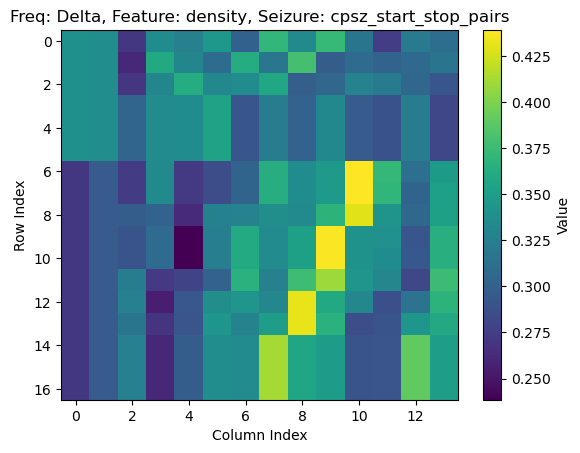

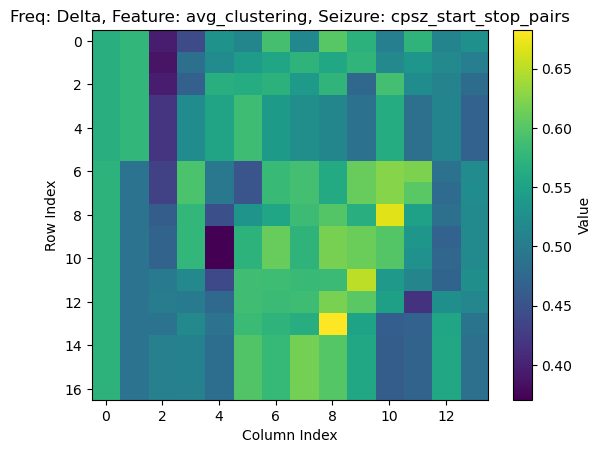

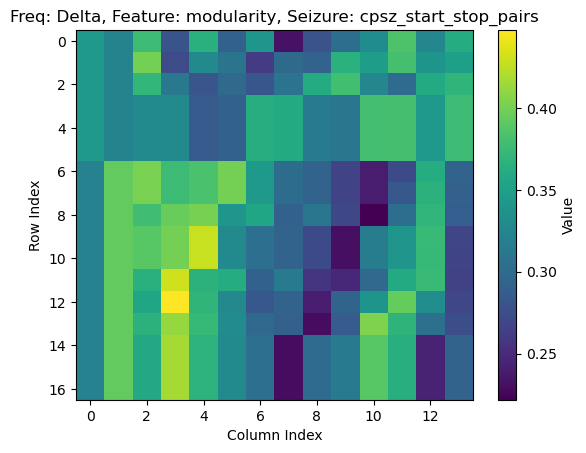

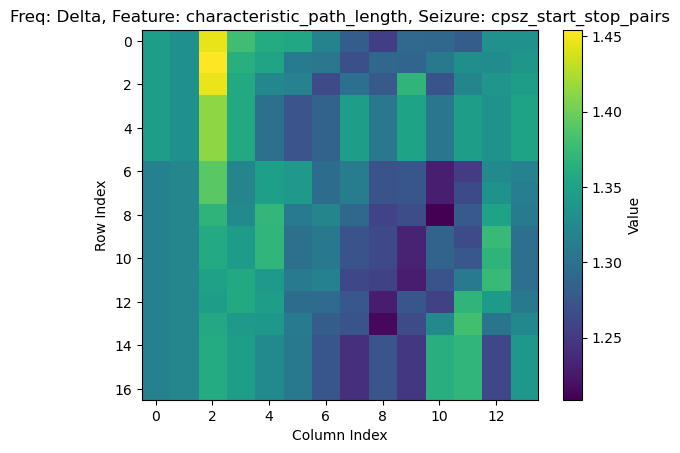

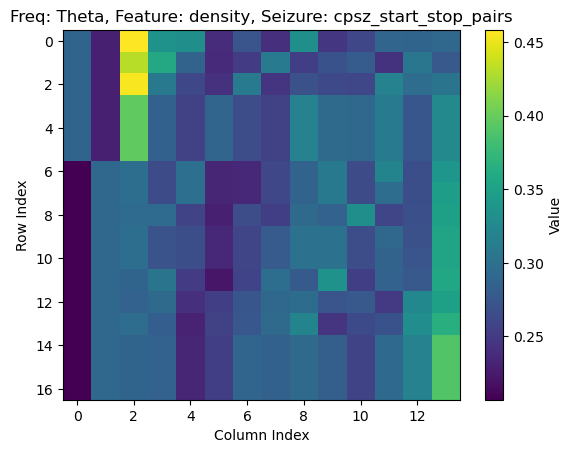

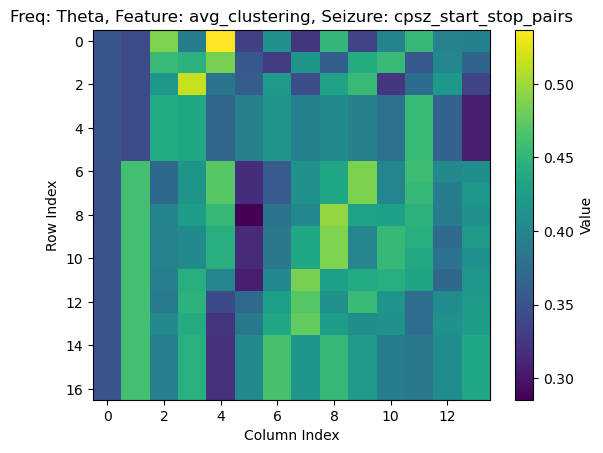

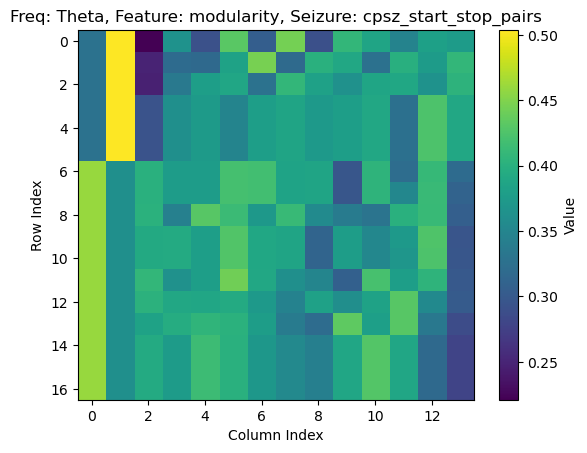

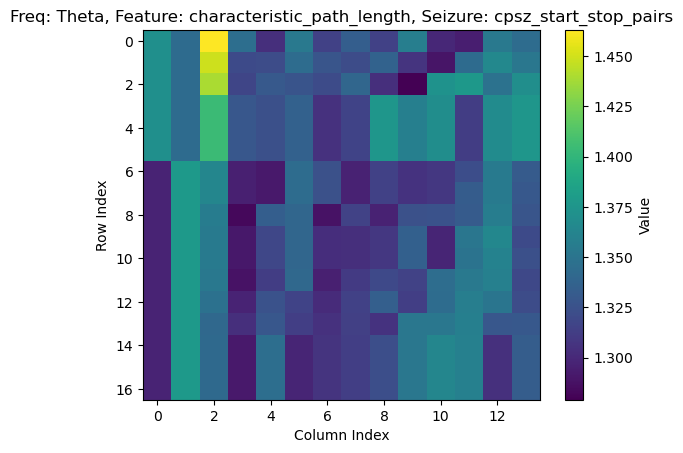

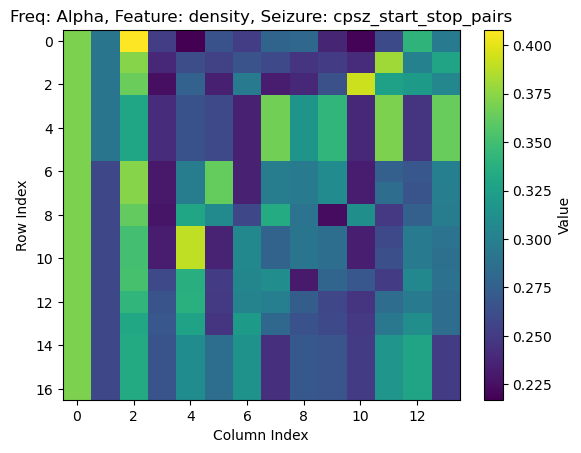

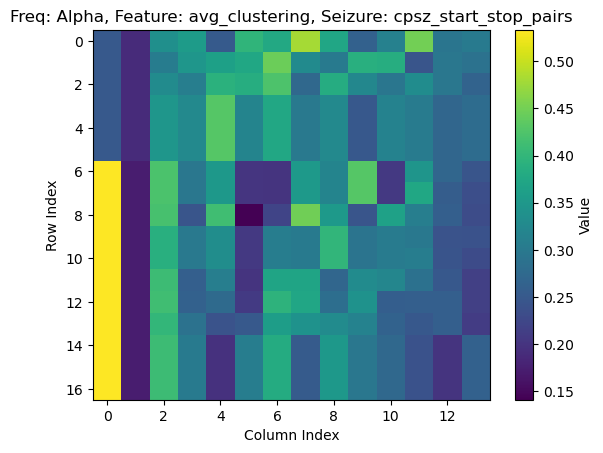

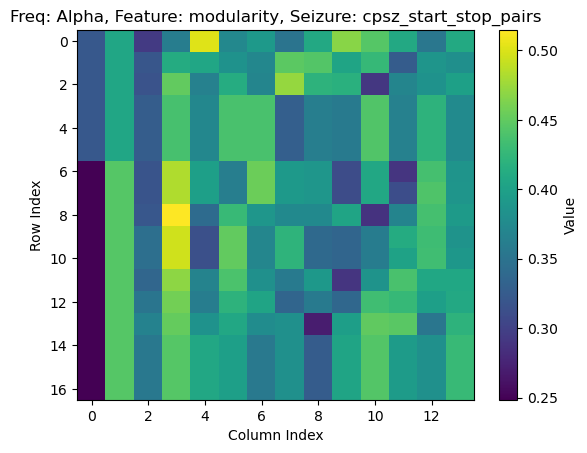

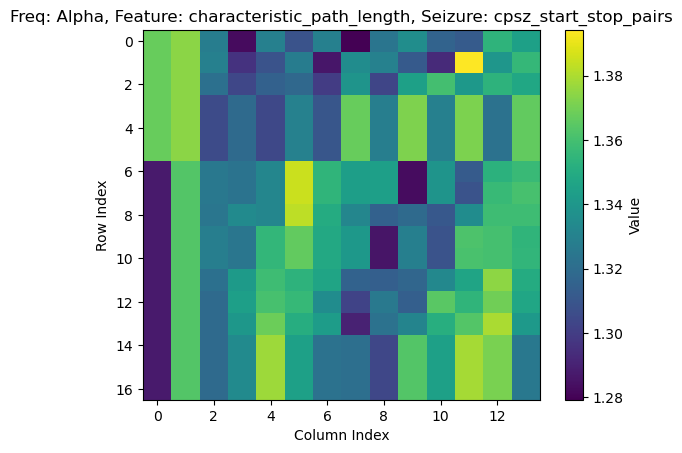

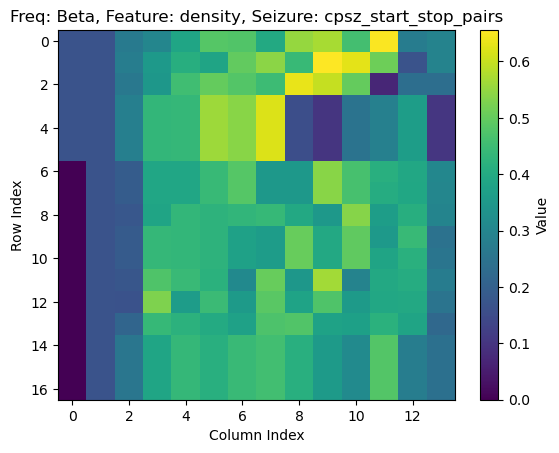

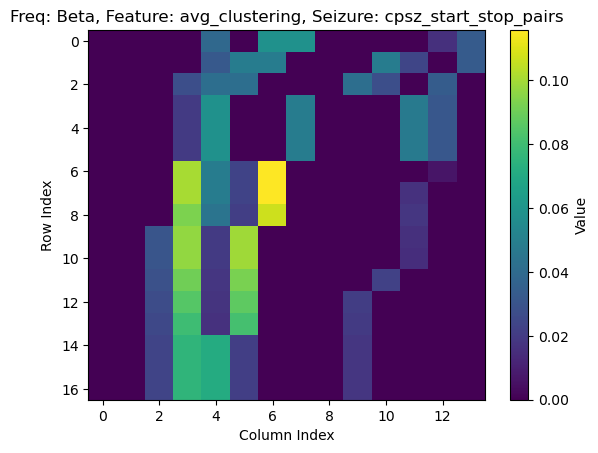

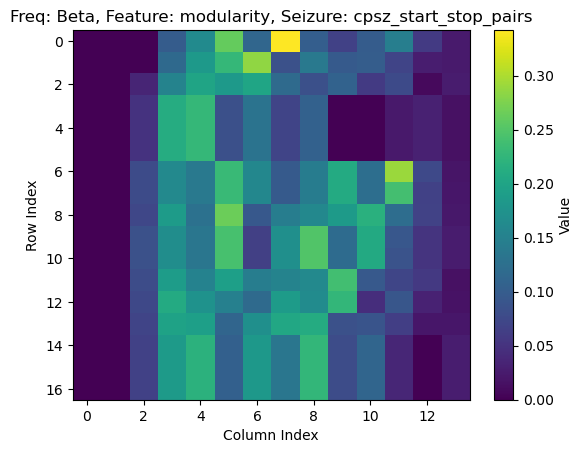

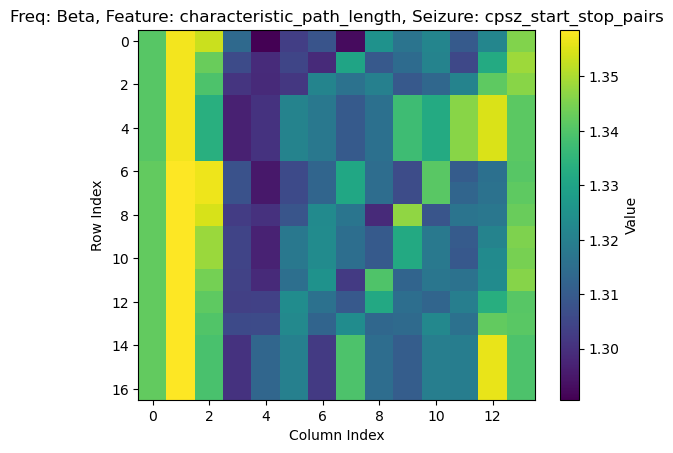

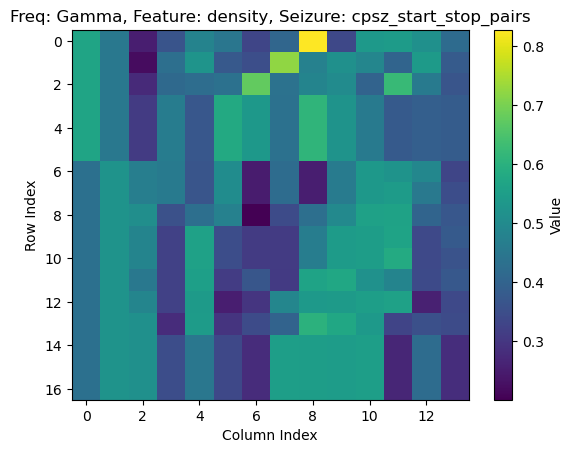

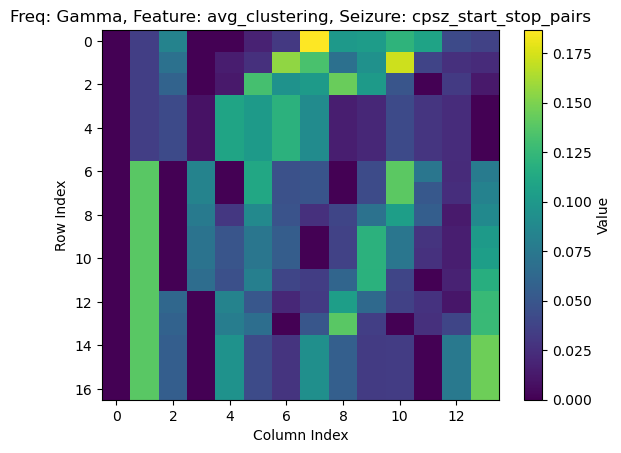

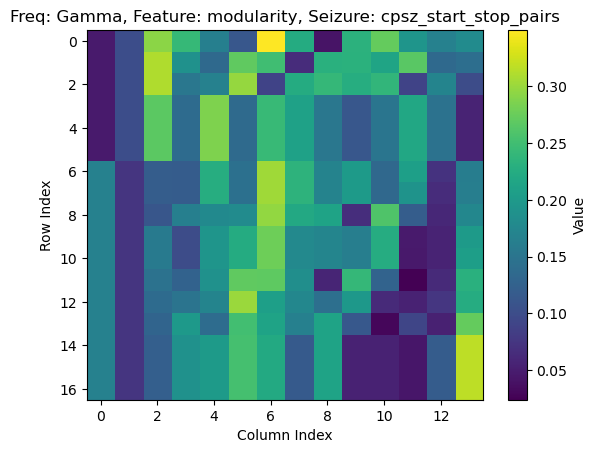

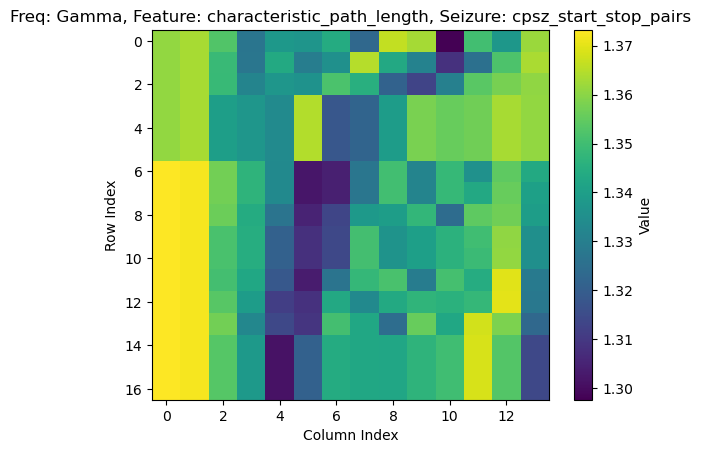

In [18]:
# Assuming 'all_results' is a dictionary structured as:
# all_results[(recording_name, frequency_band, feature, seizure_type)] = matrix

def get_seizure_types(all_results, recording_names):
    # Retrieve available seizure types across all recordings
    seizure_types = set()
    for recording in recording_names:
        for key in all_results.keys():
            if key[0] == recording:
                seizure_types.add(key[3])  # Add the seizure_type part of the key
    return list(seizure_types)

def plot_matrices_for_frequency_feature(all_results, recording_names, frequency_band, feature):
    # Retrieve available seizure types for these recordings
    seizure_types = get_seizure_types(all_results, recording_names)

    for seizure_type in seizure_types:
        # Collect the matrices for each recording and concatenate them vertically
        concatenated_matrix = []
        for recording_name in recording_names:
            key = (recording_name, frequency_band, feature, seizure_type)
            if key in all_results:
                matrix = all_results[key]
                concatenated_matrix.append(matrix)

        if concatenated_matrix:  # Only plot if there are matrices available
            # Concatenate vertically to create a single matrix
            concatenated_matrix = np.vstack(concatenated_matrix)
            
            # Plot the matrix
            plt.imshow(concatenated_matrix, cmap='viridis', aspect='auto')
            plt.colorbar(label='Value')
            plt.title(f'Freq: {frequency_band}, Feature: {feature}, Seizure: {seizure_type}')
            plt.xlabel('Column Index')
            plt.ylabel('Row Index')
            plt.show()

# Example usage
frequency_bands = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']  # frequency bands
features = ['density', 'avg_clustering', 'modularity', 'characteristic_path_length']  # features
recording_names = [0, 1]  # recording names

# Loop over each frequency band and feature to generate the plots
for frequency_band in frequency_bands:
    for feature in features:
        plot_matrices_for_frequency_feature(all_results, recording_names, frequency_band, feature)


In [20]:
import pickle
import types

# Function to check if the object is pickle-able
def is_picklable(obj):
    try:
        pickle.dumps(obj)
    except (pickle.PicklingError, AttributeError, TypeError):
        return False
    return True

# Get all variables in the notebook scope (excluding non-pickle-able objects like modules, functions, etc.)
variables_7 = {name: value for name, value in globals().items() 
             if not name.startswith('_') and is_picklable(value)
             and not isinstance(value, (types.ModuleType, types.FunctionType, types.MethodType))}

# Save variables to a file
with open('variables_7.pkl', 'wb') as f:
    pickle.dump(variables_7, f)
